In [138]:
import torch
import torchvision
import shutil 

batch_size= 32

mean = -0.1
std=1

img_size= 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../datasets/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([img_size, img_size]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=batch_size, shuffle=True)


for x,y in train_loader:
    break
    
vmin= x.min().item()
vmax= x.max().item()
print('range : ',vmin, vmax)

range :  0.10000000149011612 1.100000023841858


In [143]:
%load_ext autoreload
%autoreload 2

import torch
import shutil 
import numpy as np
from torch import nn
from modules.kernels import get_gaussian
from modules.models.forward_model import forward_modelA
from modules.models.forward_H import modelH
from modules.custom_activations import inc_m, sigmoid_custom2_with_translation
import matplotlib.pyplot as plt
from modules.models.preprocess_H_weights import ifft, fft, fft_2d, ifft_2d, fft_2d_with_fftshift, ifft_2d_with_fftshift
from modules.noise import poisson_noise


device='cuda' if torch.cuda.is_available() else 'cpu'

sPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)
exPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Notes: How to obtain different stages of the forward model

1. Ht= W (When H_weight_preproc, H_activation= unit_func)
2. Ht= Tau (When H_Activation= unit_func)
3. Ht= Ht
4. yt= lambda (When noise= False)
5. yt= yt

In [144]:

def sigmoid_custom2_with_translation(x, m, c=10, p=100, q=6):
    x_dash= p*x+ q
    return 1/(1+torch.exp(-m*x_dash + m*c))

def translation(x, m, p=100, q=6):
    return p*x+q

H_complex_init= True
X= x[0:1]
initialization_bias= 0
T= 1
m=1

####### change below hyper parameters
H_weight_preprocess= ifft_2d_with_fftshift 
H_activation= sigmoid_custom2_with_translation 
noise= True
######

H_generator = modelH(T, img_size, H_weight_preprocess, H_complex_init, device, initialization_bias, activation = H_activation).to(device)
Ht= H_generator(m)
yt = forward_modelA(X, Ht, sPSF, exPSF, device, noise, K=1000)

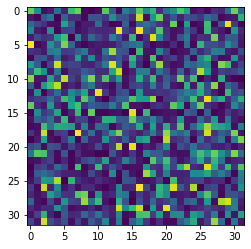

tensor(0.0194, grad_fn=<MinBackward1>) tensor(0.9840, grad_fn=<MaxBackward1>)


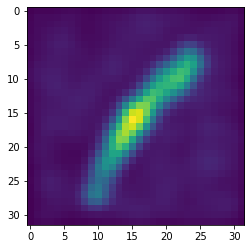

tensor(0.0072, grad_fn=<MinBackward1>) tensor(0.3437, grad_fn=<MaxBackward1>)


In [134]:
#plt.imshow(x[0,0])
#plt.show()
plt.imshow(Ht[0,0].detach().cpu().numpy())
plt.show()
print(Ht[0,0].min(), Ht[0,0].max())
plt.imshow(yt[0,0].detach().cpu().numpy())
plt.show()
print(yt[0,0].min(), yt[0,0].max())


## Visualization: Poisson Noise vs Normal Approx.

Conclusions:

* Both are in same range when min(K*X)>10

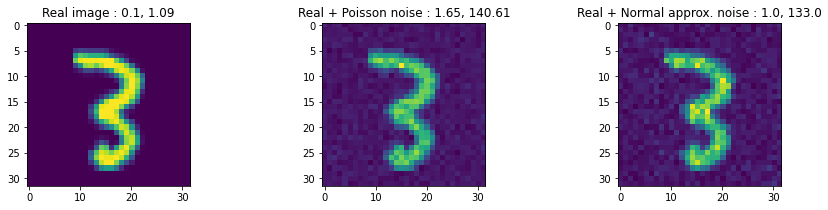

In [123]:
K= 100

z= torch.randn_like(X)  
X_poisson= torch.poisson(X[0,0]*K)
X_normal = K*(X + torch.sqrt(X/K)*z) 


plt.figure(figsize= (15, 3))
plt.subplot(1,3,1)
plt.imshow(X[0,0])
plt.title(f'Real image : {np.round(X[0,0].min().item(), 2)}, {np.round(X[0,0].max().item(), 2)}')
plt.subplot(1,3,2)
plt.imshow(X_normal[0,0])
plt.title(f'Real + Poisson noise : {np.round(X_normal[0,0].min().item(), 2)}, {np.round(X_normal[0,0].max().item(), 2)}')
plt.subplot(1,3,3)
plt.imshow(noisy)
plt.title(f'Real + Normal approx. noise : {np.round(X_poisson.min().item(), 2)}, {np.round(X_poisson.max().item(), 2)}')
plt.show()
